In [5]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
from sklearn.base import clone
from sklearn.metrics import r2_score 
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score 
import random
import shap
import sklearn.model_selection as ms
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_boston,load_diabetes,fetch_california_housing,load_linnerud,load_iris
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
import xgboost as xgb

In [6]:
boston = load_boston()

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [7]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

In [9]:
X.shape

(506, 13)

In [10]:
len(y)

506

In [11]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [12]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [52]:
#Spearman's Rank Two Variables and DataFrame

In [9]:
def Spearman_correl(x,y):

    x=np.array(x)
    y=np.array(y)
    x=np.array(pd.Series(x).rank())
    y=np.array(pd.Series(y).rank())
    xu=np.mean(x)
    yu=np.mean(y)
    Num= np.sum((x-xu)*(y-yu))
    Den= np.sqrt(np.sum((x-xu)**2)*np.sum((y-yu)**2))
    corr=Num/Den
      
    return "{:.6f}".format(corr)

In [10]:
x = [15,18,21, 15, 21]
y_n= [25,25,27,27,27]
Spearman_correl(x,y_n)

'0.456435'

In [11]:
def df_corr(df):
    df=df.dropna()
    variables=df.columns
    correl=[]
    for x in variables:
        for y in variables:
            df1 = df.dropna(subset=[x,y]).copy()
            correl.append((x,y,Spearman_correl(df1[x],df1[y])))
    new_df=pd.DataFrame(correl,columns=['1','2','3'])
    new_df=new_df.pivot_table(index='1', columns='2', values='3',aggfunc=np.sum)
    return new_df

In [12]:
def basic_PCA(X,k):
    cols=X.columns
    Xu=X - np.mean(X)
    total_var = []
    covmtrx = np.cov(Xu , rowvar = False)
    evalues , evectors = np.linalg.eigh(covmtrx)
    sort_idx = np.argsort(evalues)[::-1] 
    eval_sort = evalues[sort_idx]
    evec_sort = evectors[:,sort_idx]
    total_var= [(cols[i],evalues[i] / np.sum(evalues)) for i in range(len(evalues))]
    ncomps = k
    changed_evec = evec_sort[:,0:ncomps]
    Xred=np.dot(changed_evec.transpose(),Xu.transpose()).transpose()
    return Xred,sorted(total_var, key=lambda x: x[1],reverse=True)

In [13]:
def mrmr(X,y,num_select):
    F = pd.Series(f_regression(X, y)[0], index = X.columns)
    corr = X.corr(method="spearman").abs().clip(.00001) 

    sel = []
    ns = list(X.columns)
    for i in range(num_select):
        if i > 0:
            ls = sel[-1]
            corr.loc[ns, ls] = X[ns].corrwith(X[ls]).abs().clip(.00001)

        val = F.loc[ns] / corr.loc[ns, sel].mean(axis = 1).fillna(.00001)
        best_score = val.index[val.argmax()]
        sel.append(best_score)
        ns.remove(best_score)
    return sel


In [20]:
#y

In [30]:
print(list(X.columns))
print(mrmr(X,y,6))


['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'CRIM']


In [66]:
iris = load_iris()
X=iris.data
y=iris.target

In [68]:

mat_reduced ,m= basic_PCA(pd.DataFrame(X) , 2)
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])


In [70]:
basic_PCA(pd.DataFrame(X) , 2)

(array([[ 2.68412563,  0.31939725],
        [ 2.71414169, -0.17700123],
        [ 2.88899057, -0.14494943],
        [ 2.74534286, -0.31829898],
        [ 2.72871654,  0.32675451],
        [ 2.28085963,  0.74133045],
        [ 2.82053775, -0.08946138],
        [ 2.62614497,  0.16338496],
        [ 2.88638273, -0.57831175],
        [ 2.6727558 , -0.11377425],
        [ 2.50694709,  0.6450689 ],
        [ 2.61275523,  0.01472994],
        [ 2.78610927, -0.235112  ],
        [ 3.22380374, -0.51139459],
        [ 2.64475039,  1.17876464],
        [ 2.38603903,  1.33806233],
        [ 2.62352788,  0.81067951],
        [ 2.64829671,  0.31184914],
        [ 2.19982032,  0.87283904],
        [ 2.5879864 ,  0.51356031],
        [ 2.31025622,  0.39134594],
        [ 2.54370523,  0.43299606],
        [ 3.21593942,  0.13346807],
        [ 2.30273318,  0.09870885],
        [ 2.35575405, -0.03728186],
        [ 2.50666891, -0.14601688],
        [ 2.46882007,  0.13095149],
        [ 2.56231991,  0.367

In [72]:
pca = PCA(n_components=2)
pca.fit(X)
pca.transform(X)

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

In [73]:
print(pca.explained_variance_ratio_)

[0.92461872 0.05306648]


In [ ]:
x.shape,mat_reduced.shape

<Figure size 432x432 with 0 Axes>

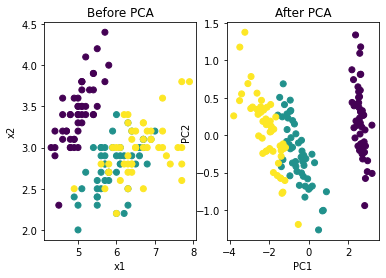

In [76]:
plt.figure(figsize = (6,6))
fig, axes = plt.subplots(1,2)
axes[0].scatter(X[:,0], X[:,1], c=y)
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_title('Before PCA')
axes[1].scatter(mat_reduced[:,0], mat_reduced[:,1], c=y)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After PCA')
plt.show()

In [77]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [78]:
corr=df_corr(X)

In [79]:
corr

2,AGE,B,CHAS,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX,ZN
1,,,,,,,,,,,,,
AGE,1.000000,-0.228022,0.067792,0.704140,-0.801610,0.679487,0.657071,0.795153,0.355384,0.417983,-0.278082,0.526366,-0.544423
B,-0.228022,1.000000,-0.039810,-0.360555,0.249595,-0.285840,-0.210562,-0.296662,-0.072027,-0.282533,0.053660,-0.329843,0.163135
CHAS,0.067792,-0.039810,1.000000,0.041537,-0.080248,0.089841,-0.050575,0.068426,-0.136065,0.024579,0.058813,-0.044486,-0.041937
CRIM,0.704140,-0.360555,0.041537,1.000000,-0.744986,0.735524,0.634760,0.821465,0.465283,0.727807,-0.309116,0.729045,-0.571660
DIS,-0.801610,0.249595,-0.080248,-0.744986,1.000000,-0.757080,-0.564262,-0.880015,-0.322041,-0.495806,0.263168,-0.574336,0.614627
INDUS,0.679487,-0.285840,0.089841,0.735524,-0.757080,1.000000,0.638747,0.791189,0.433710,0.455507,-0.415301,0.664361,-0.642811
LSTAT,0.657071,-0.210562,-0.050575,0.634760,-0.564262,0.638747,1.000000,0.636828,0.467259,0.394322,-0.640832,0.534423,-0.490074
NOX,0.795153,-0.296662,0.068426,0.821465,-0.880015,0.791189,0.636828,1.000000,0.391309,0.586429,-0.310344,0.649527,-0.634828
PTRATIO,0.355384,-0.072027,-0.136065,0.465283,-0.322041,0.433710,0.467259,0.391309,1.000000,0.318330,-0.312923,0.453345,-0.448475


In [80]:
plt.figure(figsize=(16, 6))

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

<AxesSubplot:>

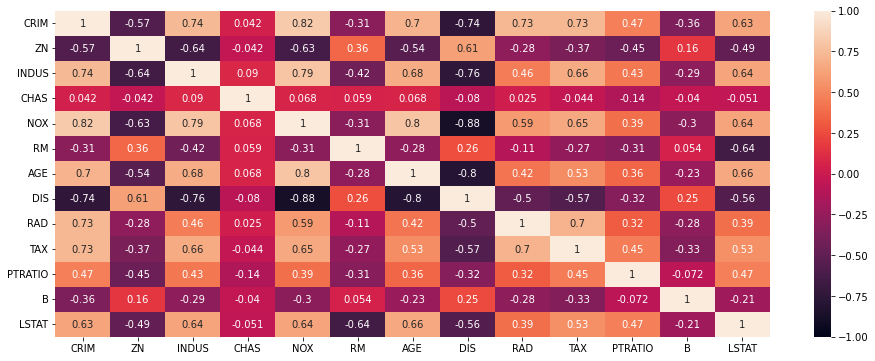

In [81]:
plt.figure(figsize=(16, 6))
sb.heatmap(X.corr(method="spearman"),vmin=-1, vmax=1, annot=True)

In [259]:
##MODEL DEPENDENT

In [86]:
#Gini

In [83]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

RandomForestRegressor()

In [84]:
rf.feature_importances_

array([0.03529088, 0.00103223, 0.00592596, 0.00078969, 0.02140345,
       0.409379  , 0.01332322, 0.06846544, 0.00485138, 0.01560073,
       0.01756597, 0.010956  , 0.39541606])

Text(0.5, 0, 'Random Forest Feature Importance')

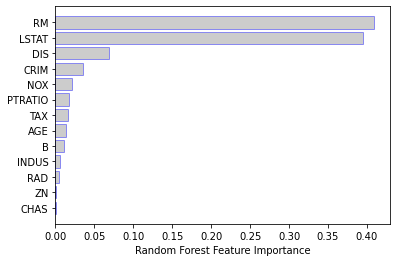

In [85]:
sortindx = rf.feature_importances_.argsort()
c = ['red', 'red', 'seagreen', 'blue', 'orange','red', 'yellow', 'seagreen', 'blue', 'orange','red', 'yellow', 'seagreen']
plt.barh(X.columns[sortindx], rf.feature_importances_[sortindx],color="grey",edgecolor="blue",alpha=0.4)
plt.xlabel("Random Forest Feature Importance")

In [87]:
#Drop Column Implementation

In [88]:
def dropcol_importances(model,metric,X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    baseline = metric(y_valid, model.predict(X_valid))
    imp = []
    X_train=pd.DataFrame(X_train)
    X_valid=pd.DataFrame(X_valid)
    for col in X_train.columns:
        X_train_ = X_train.drop(col, axis=1)
        X_valid_ = X_valid.drop(col, axis=1)
        model_ = clone(model)
        model_.fit(X_train_, y_train)
        m = metric(y_valid, model_.predict(X_valid_))
        imp.append((col,baseline - m))
    return imp

In [89]:
#Permutation Implementation

In [90]:
def permutation_importances(model, metric,X_valid, y_valid):
    baseline = metric(y_valid, model.predict(X_valid))
    imp = []
    X_valid=pd.DataFrame(X_valid)
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        m = metric(y_valid, model.predict(X_valid))
        X_valid[col] = save
        imp.append((col,baseline - m))
    return imp

In [93]:
def rsquared(actual,predict):
    corr_matrix = np.corrcoef(actual, predict)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq
 

In [95]:
model = RandomForestRegressor(n_estimators=100)
dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val)

[('CRIM', 0.009426962460162502),
 ('ZN', 0.017610365717485088),
 ('INDUS', -0.010145342231250631),
 ('CHAS', 0.02288352049258846),
 ('NOX', 0.039239746873186765),
 ('RM', 0.133884302728148),
 ('AGE', 0.00182890844821737),
 ('DIS', 0.04828877731278869),
 ('RAD', 0.004949283631567547),
 ('TAX', 0.01688882855149998),
 ('PTRATIO', 0.013536517540586268),
 ('B', 0.0009526389190764872),
 ('LSTAT', 0.2123860294045633)]

Text(0.5, 1.0, 'Drop Column Importance')

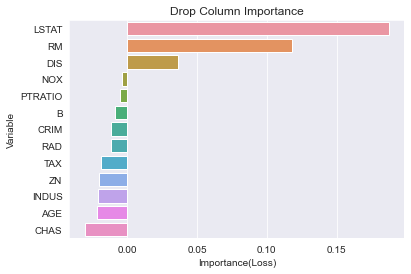

In [96]:
df = pd.DataFrame(dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val),columns=['Variable','Importance'])
sortindx = df['Importance'].argsort()[::-1]
sb.set_style("darkgrid")
p=sb.barplot(x='Importance', y='Variable', data=df.iloc[sortindx],orient='h')
#sb.xlabel("Importance(Loss)")
p.set_xlabel('Importance(Loss)')
p.set_title('Drop Column Importance')


Text(0.5, 1.0, 'Permutation Importance')

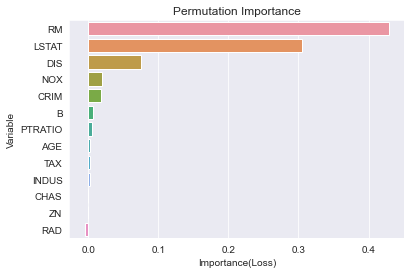

In [99]:
df = pd.DataFrame(permutation_importances(model, rsquared,X_val, y_val),columns=['Variable','Importance'])
sortindx = df['Importance'].argsort()[::-1]
sb.set_style("darkgrid")
p=sb.barplot(x='Importance', y='Variable', data=df.iloc[sortindx],orient='h')
#sb.xlabel("Importance(Loss)")
p.set_xlabel('Importance(Loss)')
p.set_title('Permutation Importance')

In [100]:
scoring = 'r2'#, 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'
r_multi = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0, scoring=scoring)

In [101]:
r_multi['importances_mean']

array([ 2.58407957e-02, -2.02065022e-04,  1.62215228e-03, -2.23452816e-04,
        2.00782131e-02,  3.91286366e-01,  4.70348826e-03,  5.76024064e-02,
       -2.43397463e-03,  5.83783623e-03,  1.96639848e-02,  7.86253469e-03,
        5.41544747e-01])

In [102]:
permutation_importances(model, rsquared,X_val, y_val)

[('CRIM', 0.03783131321525712),
 ('ZN', -0.0002993517444340732),
 ('INDUS', 0.0010366172596999457),
 ('CHAS', -0.0008645716552038163),
 ('NOX', 0.02453749159431151),
 ('RM', 0.37902173266994293),
 ('AGE', 0.00354451924961785),
 ('DIS', 0.05445099800283737),
 ('RAD', -0.002711206780829034),
 ('TAX', 0.01679262355273159),
 ('PTRATIO', 0.02082915683613895),
 ('B', 0.007367766438903134),
 ('LSTAT', 0.722418640891854)]

In [104]:
model = Ridge(alpha=1e-2) #Different model
dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val)

[('CRIM', 0.0049856854610029755),
 ('ZN', 0.009477233191896972),
 ('INDUS', -0.00022709563633627194),
 ('CHAS', 0.008120298385071667),
 ('NOX', 0.020046083662205727),
 ('RM', 0.05526047171117354),
 ('AGE', -0.0012486001579956607),
 ('DIS', 0.03964654912910259),
 ('RAD', 0.021570266571364294),
 ('TAX', 0.00919121942621548),
 ('PTRATIO', 0.017637408132317844),
 ('B', 0.009115828036576068),
 ('LSTAT', 0.08109535502163079)]

In [105]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

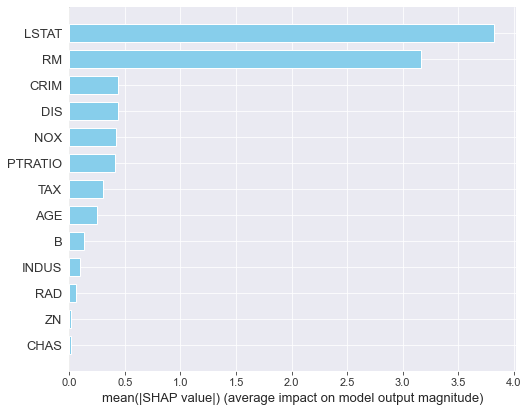

In [206]:
shap.summary_plot(shap_values, X_train, plot_type="bar",color="skyblue")

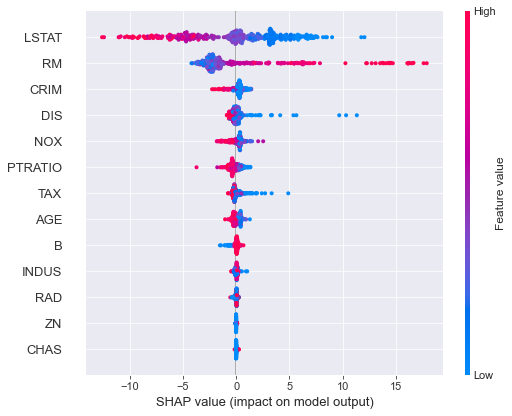

In [107]:
shap.summary_plot(shap_values, X_train)

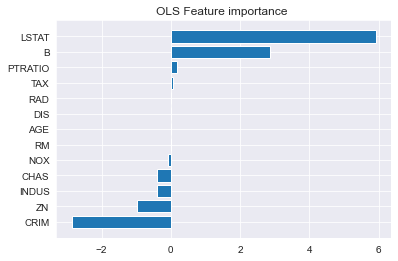

In [228]:
import statsmodels.api as sm
#model=LinearRegression()
model = sm.OLS(y,X)
results=model.fit()#(X_train,y_train)
importance=results.params
importance=np.sort(importance)
sns.set_style("darkgrid")
plt.barh(X.columns,importance)
plt.title('OLS Feature importance ')
plt.show()

In [13]:
model=Ridge()

In [14]:
def automatic_feature_select(model,metric,method_imp,X_train, y_train, X_valid, y_valid):
    X_train=np.array(X_train)
    columns_dataframe=pd.DataFrame(X_train).columns
    model.fit(X_train, y_train)
    baseline = metric(y_valid, model.predict(X_valid))
    scoring = 'neg_mean_absolute_percentage_error'
    if method_imp=='permutation':
        r_multi = permutation_importance(model, X_valid, y_valid, n_repeats=30, random_state=0, scoring=scoring)['importances_mean']
    if method_imp=='drop':
        r_multi= dropcol_importances(model, metric,X_train, y_train,X_valid, y_valid)[1]  
    r_multi=np.vstack((np.arange(X_train.shape[1]), r_multi)).T
    r_multisort=r_multi.copy()
    r_multisort=r_multi[r_multi[:, 1].argsort()]
    rem_X_train=X_train.copy()
    rem_X_valid=X_valid.copy()
    dropped_indexes=[]
    #print(rem_X_train)
    for k in range(0,len(columns_dataframe)):
        print(rem_X_train.shape)
        rem_X_train=np.delete(np.array(rem_X_train),0 , 1)
        rem_X_valid=np.delete(np.array(rem_X_valid), 0, 1)
        model.fit(rem_X_train, y_train)
        new_val_metric = metric(y_valid, model.predict(rem_X_valid))
        if (abs(baseline-new_val_metric)*1.00/baseline)>0.05:
            break
        else:
            dropped_indexes.append(r_multisort[0][0])
            r_multi=np.delete(r_multi,np.where(r_multi[:,0]==r_multisort[0][0]),0)
            if method_imp=='permutation':
                r_multi_new= permutation_importance(model, rem_X_valid, y_valid, n_repeats=30, random_state=0, scoring=scoring)['importances_mean']
                r_multi_new=np.vstack((r_multi[:,0], r_multi_new)).T
                
            if method_imp=='drop':
                r_multi_new= dropcol_importances(model, metric,X_train, y_train,X_valid, y_valid)[1]
                r_multi_new=np.vstack((r_multi[:,0], r_multi_new)).T
                
            r_multisort=r_multi_new.copy()
            r_multisort=r_multisort[r_multisort[:, 1].argsort()]
    return r_multisort,dropped_indexes
        

In [15]:
X_train.shape

(379, 13)

In [16]:
np.arange(X_train.shape[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [17]:
#model = RandomForestRegressor(n_estimators=20)

In [216]:
selected,dropped=automatic_feature_select(model,mape,"permutation",X_train, y_train, X_val, y_val)

X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitte

X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitted without feature names
X has feature names, but Ridge was fitte

(379, 13)
(379, 12)
(379, 11)
(379, 10)
(379, 9)
(379, 8)


In [217]:
list(selected[:,0].astype(int))

[1, 11, 10, 9, 8, 7, 0, 12]

In [219]:
X.columns[selected[:,0].astype(int)]

Index(['ZN', 'B', 'PTRATIO', 'TAX', 'RAD', 'DIS', 'CRIM', 'LSTAT'], dtype='object')

Text(0.5, 1.0, 'Drop Column Importance')

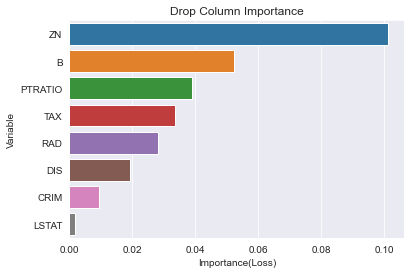

In [220]:

sortindx = selected[:,1].argsort()[::-1]
sorted_drop=pd.DataFrame(selected,columns=['Variable','Importance']).iloc[sortindx]
sorted_drop["Variable"]=X.columns[list(selected[:,0].astype(int))]
sb.set_style("darkgrid")
p=sb.barplot(x='Importance', y='Variable', data=sorted_drop,orient='h')
p.set_xlabel('Importance(Loss)')
p.set_title('Drop Column Importance')



In [20]:
#model=LogisticRegression()
#model.fit(X,y)
model = Ridge(alpha=1e-2)
model.fit(X_train,y_train)

Ridge(alpha=0.01)

In [1]:
#Variance of Feature Importance: BootStrapping

In [178]:
def var_fi(data, times):
    varimps=[]
    for i in range(0,times):
        print(i)
        bootsp_data_X=pd.DataFrame(np.hstack((data.data,data.target.reshape(-1,1)))).sample(frac=0.5, replace=False)
        X_train, X_val, y_train, y_val = train_test_split(bootsp_data_X.iloc[:,:-1], bootsp_data_X.iloc[:,-1])
        imp=pd.DataFrame(permutation_importances(model, rsquared,X_val, y_val),columns=['Variable','Importance'])
        #dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val)
        sc = MinMaxScaler(feature_range=(0, 1))
        data_norm = sc.fit_transform(np.array(imp)[:,1].reshape(-1,1))
        imp=np.hstack((np.array(imp)[:,0].reshape(-1,1),data_norm))
        varimps.append(imp)
    cols=bootsp_data_X.shape[1]-1 
    var_df=pd.DataFrame(np.array(varimps).reshape(cols*times,2))
    var_df.columns=['col','val_vi']
    result = var_df.groupby(['col'], as_index=False).agg({'val_vi':['mean','std','count']})
    result['relative_mean']=(result['val_vi']['mean']*1.00)/sum(result['val_vi']['mean'])
    result['max_CI']=(result['relative_mean']+(2*result['val_vi']['std']/np.sqrt(result['val_vi']['count'])))/2
    result['min_CI']=(result['relative_mean']-(2*result['val_vi']['std']/np.sqrt(result['val_vi']['count'])))/2
    return var_df,result
    

In [179]:
turn=30
saveimps,df_1=var_fi(boston, turn)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names

16
17
18
19
20
21
22
23
24
25
26
27
28
29


X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names
X does not have valid feature names, but Ridge was fitted with feature names

Text(0, 0.5, 'Feature importance Variance')

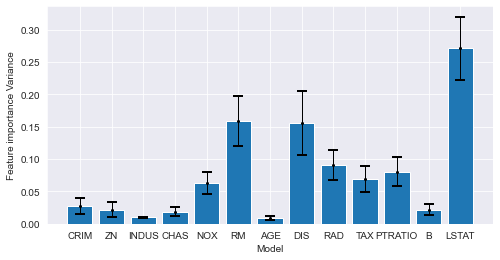

In [185]:
plt.figure(figsize = (8,4))
plt.errorbar( X.columns, df_1['relative_mean'], yerr=r["importances_std"], fmt='o', color='Black', elinewidth=1,capthick=2,errorevery=1, alpha=1, ms=2, capsize = 5)
plt.bar(X.columns, df_1['relative_mean'],tick_label = X.columns)##Bar plot
plt.xlabel('Model') ## Label on X axis
plt.ylabel('Feature importance Variance') ##Label on Y axis



In [186]:
#Calculate p-value

def pvalue_fi(data,runs):
    null_imp_df = pd.DataFrame()
    nb_runs = runs
    start = time.time()
    data_X=pd.DataFrame(np.hstack((data.data,data.target.reshape(-1,1))))
    add_counts=np.zeros((data_X.shape[1])-1)
    X_train, X_val, y_train, y_val = train_test_split(data_X.iloc[:,:-1], data_X.iloc[:,-1])
    baseline_imp_df = dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val)
    for i in range(nb_runs):
        y_train=y_train.sample(frac=1, replace=False)
        upd_imp_df = dropcol_importances(model, rsquared,X_train, y_train,X_val, y_val)
        conditn=np.where(((np.array(upd_imp_df)[:,1]-np.array(baseline_imp_df)[:,1]))>=0,1,0)
        gain_loss=pd.DataFrame(((np.array(upd_imp_df)[:,1])))
        add_counts=add_counts+conditn
        intm_df=pd.concat([pd.DataFrame(np.arange(X_train.shape[1])), pd.DataFrame(conditn),gain_loss], axis=1)
        intm_df.columns=['col','count','gain_loss']
        intm_df['run'] = i + 1 
        null_imp_df = pd.concat([null_imp_df, intm_df], axis=0)
        #if i%10==0:
            #print(i)

    add_counts=(add_counts*1.00)/(nb_runs)
    thresh=np.where(np.array(add_counts)>=0.05,0,1)
    baseline_imp_df=pd.DataFrame(baseline_imp_df,columns=['col','gain_loss'])
    return add_counts,thresh,null_imp_df,baseline_imp_df



In [187]:
counts,selected,vi_df,bdf=pvalue_fi(boston,200)

In [197]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

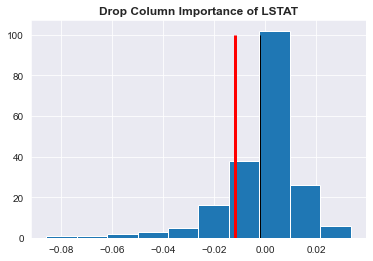

In [198]:
plt.hist(vi_df.loc[vi_df['col']==12,'gain_loss'].values,label='Null importances')
plt.vlines(bdf.loc[bdf['col']==12,'gain_loss'].values, ymin=0, ymax=100,color='r',linewidth=3, label='Real Target')
plt.vlines(vi_df.loc[vi_df['col']==12,'gain_loss'].mean(), ymin=0, ymax=100,color='black',linewidth=1, label='Mean of Distribution')
#plt.xlim(xmin=-0.15, xmax = 0.15)
plt.title('Drop Column Importance of LSTAT', fontweight='bold')
plt.show()

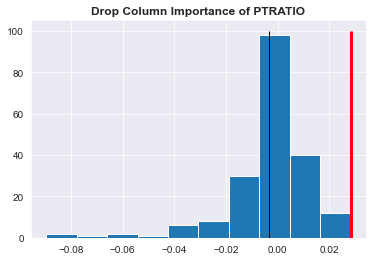

In [199]:
plt.hist(vi_df.loc[vi_df['col']==10,'gain_loss'].values,label='Null importances')
plt.vlines(bdf.loc[bdf['col']==10,'gain_loss'].values, ymin=0, ymax=100,color='r',linewidth=3, label='Real Target')
plt.vlines(vi_df.loc[vi_df['col']==10,'gain_loss'].mean(), ymin=0, ymax=100,color='black',linewidth=1, label='Mean of Distribution')
plt.title('Drop Column Importance of PTRATIO', fontweight='bold')
plt.show()

In [21]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [95]:
len(selected[:,0])

8

In [174]:
def plot_selc(X,k):
    results = []   
    for i in range(1,k+1):
        X = pd.DataFrame(boston.data, columns=boston.feature_names)
        y = boston.target
        filtered_data=X.iloc[:,selected[:,0]]
        X=filtered_data[filtered_data.columns[:i]]
        models = []
        #models.append(('Ridge', Ridge(1e-5)))
        models.append(('OLS', LinearRegression()))
        models.append(('RF', RandomForestRegressor()))
        models.append(('XGB', xgb.XGBRegressor()))
        names = []
        scoring = 'neg_mean_absolute_error'
        for name, model in models:
            kfold = ms.KFold(n_splits=10)
            cv_results = ms.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
            results.append((name,i,cv_results.mean()))
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

    return results

In [175]:
results=plot_selc(X,len(selected[:,0]-2))

OLS: -6.288458 (2.208258)
RF: -7.745267 (2.202899)
XGB: -6.724160 (1.986992)
OLS: -6.235139 (2.300066)
RF: -7.071103 (1.983474)
XGB: -6.393247 (1.960591)
OLS: -5.215537 (1.903365)
RF: -6.452412 (2.536006)
XGB: -5.733966 (1.786597)
OLS: -5.245020 (1.844193)
RF: -6.224869 (2.610519)
XGB: -5.794624 (1.910367)
OLS: -5.234591 (1.898231)
RF: -6.308920 (2.767562)
XGB: -5.629747 (1.721443)
OLS: -5.198449 (1.878228)
RF: -5.389865 (1.544311)
XGB: -5.098916 (1.466843)
OLS: -5.349665 (2.065385)
RF: -5.532685 (1.509434)
XGB: -5.209621 (1.568705)
OLS: -4.076282 (1.091513)
RF: -3.553962 (1.003554)
XGB: -3.520358 (1.062123)


In [176]:
results_df=pd.DataFrame(results,columns=['Model','K','MAPE'])

In [177]:
pivot_table_df = pd.pivot_table(
    results_df,
    index='K',
    columns='Model',
    values='MAPE',
    aggfunc=np.sum,
    margins=True
)

In [178]:
pivot_table_df=pivot_table_df[pivot_table_df.columns[:3]]

In [182]:
pivot_table_df

Model,OLS,RF,XGB
K,,,
1,-6.288458,-7.745267,-6.724160
2,-6.235139,-7.071103,-6.393247
3,-5.215537,-6.452412,-5.733966
4,-5.245020,-6.224869,-5.794624
5,-5.234591,-6.308920,-5.629747
6,-5.198449,-5.389865,-5.098916
7,-5.349665,-5.532685,-5.209621
8,-4.076282,-3.553962,-3.520358


In [183]:
pivot_table_df= pivot_table_df[:-1]

Text(0.5, 1.0, 'Comparison of Algorithms for Top K features')

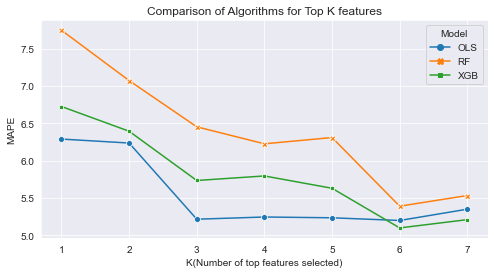

In [221]:
plt.figure(figsize = (8,4))
sb.lineplot(data=pivot_table_df.abs(),markers=True, dashes=False,err_style="bars")
plt.xlabel('K(Number of top features selected)')
plt.ylabel('MAPE') 
plt.title('Comparison of Algorithms for Top K features')


In [165]:
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()